In [258]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
import copy

## Load the input grayscale image (input/ps1-input0.png) as img and generate an edge image – which is a binary image with white pixels (1) on the edges and black pixels (0) elsewhere.

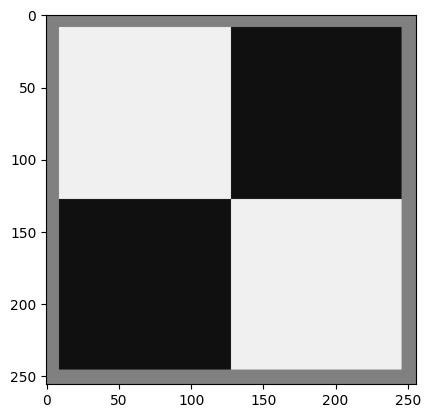

In [259]:
input0_image = cv2.imread("./input/ps1-input0.png")
plt.imshow(input0_image)

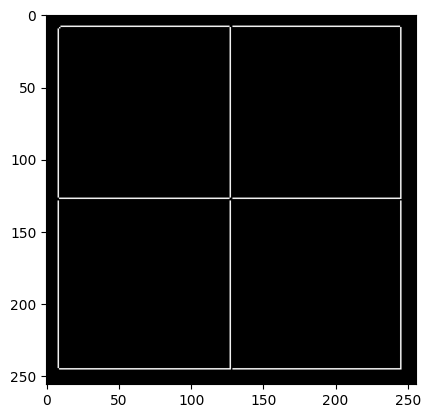

In [260]:
edges = cv2.Canny(input0_image, 100, 200)
plt.imshow(edges, cmap="gray")

### Implement a Hough Transform method for finding lines. Note that the coordinate system used is as pictured below with the origin placed one pixel above and to the left of the upper-left pixel of the image and with the Y-axis pointing downwards.

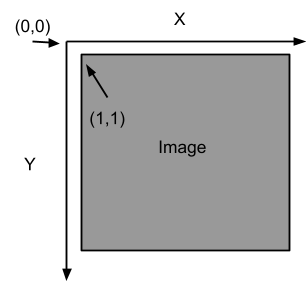

## Thus, the pixel at img(r,c) corresponds to the (x,y) coordinates (r,c), i.e. x=c and y=r. This pixel should vote for line parameters (ρ,θ) where: ρ = x⋅cos(θ) + y⋅sin(θ), and θ = atan2(y,x).

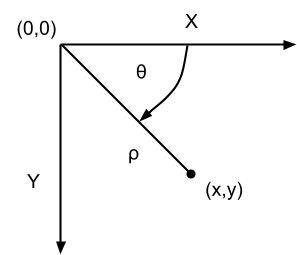

## This has the effect of making the positive angular direction clockwise instead of counter-clockwise in the usual convention. Theta (θ) = zero still points in the direction of the positive X-axis.

Write a function hough_lines_acc that computes the Hough Transform for lines and produces an accumulator array. Your code should conform to the specifications of the Matlab function hough: http://www.mathworks.com/help/images/ref/hough.html<br>
Note that it has two optional parameters RhoResolution and Theta, and returns three values - the hough accumulator array H, theta (θ) values that correspond to columns of H and rho (ρ) values that correspond to rows of H.<br><br><br>



Apply it to the edge image (img_edges) from question 1:<br>
        &emsp;&emsp;&emsp; [H, theta, rho] = hough_lines_acc(img_edges);<br>
Or, with one optional parameter specified (θ = integers -90 to 89, i.e. 180 values including 0):<br>
        &emsp;&emsp;&emsp; [H, theta, rho] = hough_lines_acc(img_edges, 'Theta', -90:89);

In [261]:
def hough_lines_acc(edges, rho_res=1, thetas=np.arange(-90.0, 90.0, 1)):
  width, height = edges.shape
  diag_len = np.ceil(np.sqrt(width * width + height * height))  
  rhos = np.arange(-diag_len, diag_len, rho_res)
  cos_t = np.cos(np.deg2rad(thetas))
  sin_t = np.sin(np.deg2rad(thetas))
  num_thetas = len(thetas)
  accumulator = np.zeros((len(rhos), num_thetas), dtype=np.uint64)
  y_idxs, x_idxs = np.nonzero(edges)
  for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]
    for t_idx in range(num_thetas):
      rho = np.ceil((((x * cos_t[t_idx] + y * sin_t[t_idx])) + diag_len)/rho_res)
      accumulator[int(rho), t_idx] += 1
  return accumulator, thetas, rhos
    

Write a function hough_peaks that finds indices of the accumulator array (here line parameters) that correspond to local maxima. Your code should conform to the specifications of the Matlab function houghpeaks:
http://www.mathworks.com/help/images/ref/houghpeaks.html
Note that you need to return a Qx2 matrix with row indices (here rho) in column 1, and column indices (here theta) in column 2. (This could be used for other peak finding purposes as well.)

Call your function with the accumulator from the step above to find up to 10 strongest lines:
        peaks = hough_peaks(H, 10);

In [262]:
def hough_peaks(h, thresh=None, top_n=10, n_size=None, disable_plt=False):
    q = []
    h = h.copy()
    for i in range(top_n):
        max_value = 0
        max_idxs = ()
        for rho_idx, row in enumerate(h):
            for theta_idx, votes in enumerate(row):
                if votes > max_value:
                    max_value = votes
                    max_idxs = (rho_idx, theta_idx)
        
        if (thresh) and (max_value < thresh):
            if not disable_plt:
                print(f"peaks found by threshold: {i}")
                plt.imshow(h, cmap="gray")
            return q
        if n_size:
            h[max_idxs[0]-n_size:max_idxs[0]+n_size, max_idxs[1]-n_size:max_idxs[1]+n_size] = 0
        else:
            h[max_idxs[0], max_idxs[1]]=0
        q.append(max_idxs)
    if not disable_plt:
        plt.imshow(h, cmap="gray")
    return q

Write a function hough_lines_draw to draw color lines that correspond to peaks found in the accumulator array. This means you need to look up rho, theta values using the peak indices, and then convert them (back) to line parameters in cartesian coordinates (you can then use regular line-drawing functions).

Use this to draw lines on the original grayscale (not edge) image. The lines should extend to the edges of the image (aka infinite lines):
        hough_lines_draw(img, 'ps1-2-c-1.png', peaks, rho, theta);

peaks found by threshold: 6


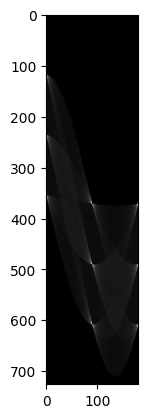

In [263]:
h, thetas, rhos = hough_lines_acc(edges, 1, np.arange(-90, 90, 1))
peaks = hough_peaks(h, thresh=100)

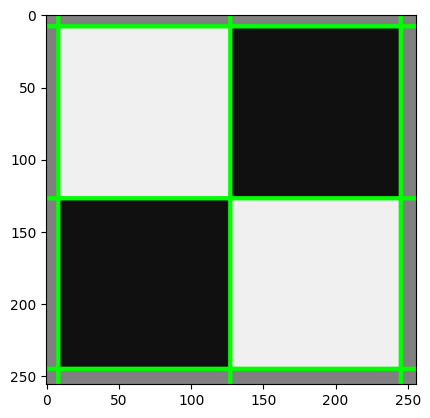

In [264]:
input0_image = cv2.imread("./input/ps1-input0.png")


def hough_lines_draw(img, outfile, peaks, rhos, thetas):
    for peak in peaks:
        rho = rhos[peak[0]]
        theta = thetas[peak[1]]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        pt0 = rho * np.array([a,b])
        pt1 = tuple((pt0 + 1000 * np.array([-b,a])).astype(int))
        pt2 = tuple((pt0 - 1000 * np.array([-b,a])).astype(int))
        cv2.line(img, pt1, pt2, (0,255,0), 2)
    cv2.imwrite(outfile, img)
    plt.imshow(img[:,:,::-1])
    return img
    
img = hough_lines_draw(input0_image, "./output/ps1-2-c-1.png", peaks, rhos, thetas)

### Now we’re going to add some noise.

Use ps1-input0-noise.png - same image as before, but with noise. Compute a modestly smoothed version of this image by using a Gaussian filter. Make σ at least a few pixels big.

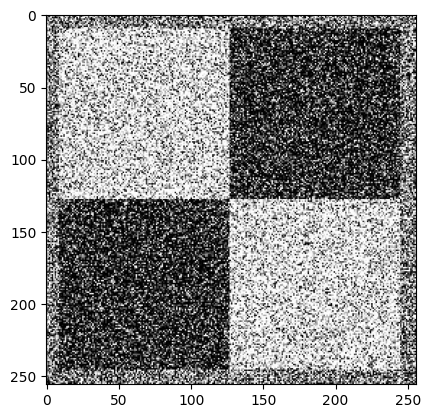

In [265]:
input0_noise = cv2.imread('./input/ps1-input0-noise.png')
plt.imshow(input0_noise)

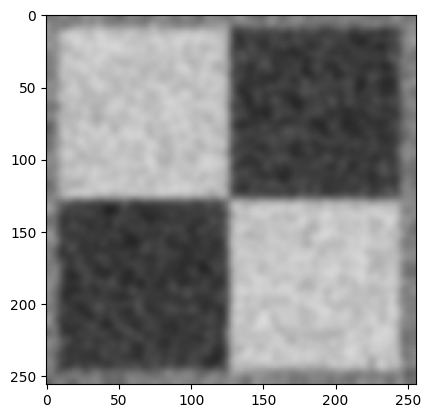

In [266]:
sigma = 1
input0_noise_smoothed = cv2.GaussianBlur(input0_noise, (19,19), 3)
plt.imshow(input0_noise_smoothed)

Using an edge operator of your choosing, create a binary edge image for both the original image (ps1-input0-noise.png) and the smoothed version above.

Text(0.5, 1.0, 'smooth image edges')

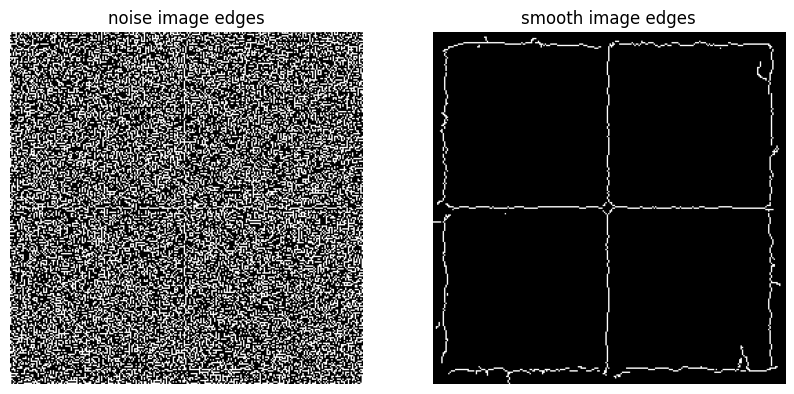

In [267]:
edge_noise = cv2.Canny(input0_noise, 200, 255)
edge_smooth = cv2.Canny(input0_noise_smoothed, 25, 80)

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
  
plt.imshow(edge_noise, cmap="gray")
plt.axis('off')
plt.title("noise image edges")

fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(edge_smooth, cmap="gray")
plt.axis('off')
plt.title("smooth image edges")

Now apply your Hough method to the smoothed version of the edge image. Your goal is to adjust the filtering, edge finding, and Hough algorithms to find the lines as best you can in this test case.

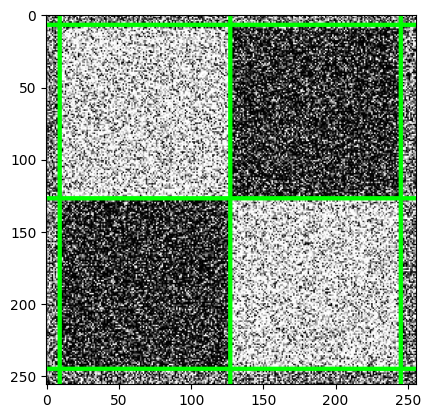

In [268]:
input0_noise = cv2.imread('./input/ps1-input0-noise.png')
h, thetas, rhos = hough_lines_acc(edges, 2, np.arange(-90,90,2))
peaks = hough_peaks(h, top_n=6)
image = hough_lines_draw(input0_noise, './output/ps1-3-c-2.png', peaks=peaks, rhos=rhos, thetas=thetas)

### For this question use: ps1-input1.png

This image has objects in it whose boundaries are circles (coins) or lines (pens). For this question  you’re still finding lines. Load/create a monochrome version of the image (you can pick a single color channel or use a built-in color to grayscale conversion function), and compute a modestly smoothed version of this image by using a Gaussian filter. Make σ at least a few pixels big.

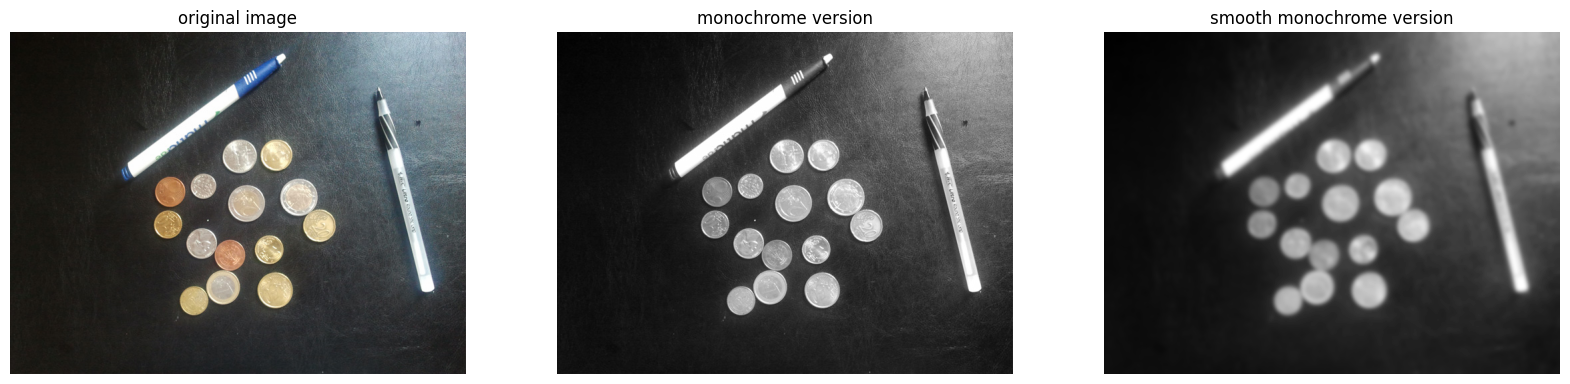

In [269]:
circles = cv2.imread("./input/ps1-input1.png")
circles_monochrome = cv2.cvtColor(circles, cv2.COLOR_BGR2GRAY)
circles_smooth = cv2.GaussianBlur(circles_monochrome, (19,19), 3)




fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)
  
plt.imshow(circles[:, :, ::-1])
plt.axis('off')
plt.title("original image")

fig.add_subplot(rows, columns, 2)
  
plt.imshow(circles_monochrome, cmap="gray")
plt.axis('off')
plt.title("monochrome version")

fig.add_subplot(rows, columns, 3)

plt.imshow(circles_smooth, cmap="gray")
plt.axis('off')
plt.title("smooth monochrome version")

plt.show()

Create an edge image for the smoothed version above.

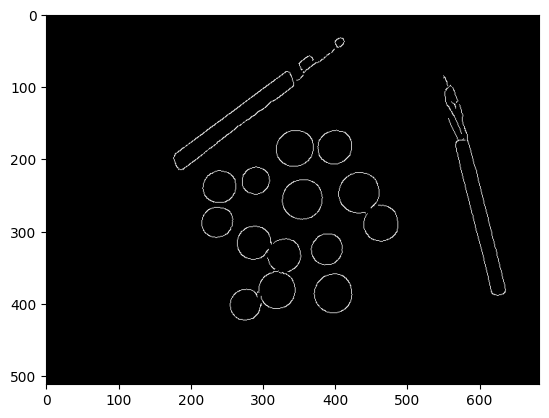

In [270]:
edges = cv2.Canny(circles_smooth, 40, 100)
plt.imshow(edges, cmap="gray")

Apply your Hough algorithm to the edge image to find lines along the pens. Draw the lines in color on the  original monochrome (not edge) image. The lines can extend to the edges of the image.

peaks found by threshold: 4


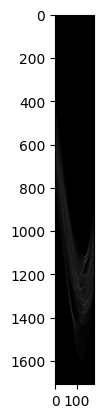

In [271]:
h, thetas, rhos = hough_lines_acc(edges)
peaks = hough_peaks(h, thresh=125)

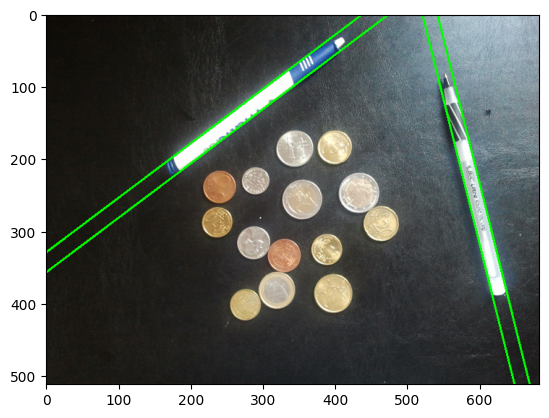

In [272]:
_ = hough_lines_draw(circles, './output/ps1-4-c-2.png', peaks, rhos, thetas)

### Now write a circle finding version of the Hough transform. You can implement either the single point method or the point plus gradient method. WARNING: This part may be hard!!! Leave extra time!<br> If you find your arrays getting too big (hint, hint) you might try make the range of radii very small to start with and see if you can find one size circle. Then maybe try the different sizes.


Implement hough_circles_acc to compute the accumulator array for a given radius.
Using the same original image (monochrome) as above (ps1-input1.png), smooth it, find the edges (or directly use edge image from 4-b above), and try calling your function with radius = 20:

In [273]:
def hough_circles_acc(edges, radius):
    width, height = edges.shape
    accumulator = np.zeros((width, height), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(edges)
    theta=np.deg2rad(np.arange(0,360))
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
    
        a = (y - radius * np.sin(theta)).astype(np.uint)
        b = (x - radius * np.cos(theta)).astype(np.uint)
        a = a % (width -1)
        b = b % (height -1)
        # a = np.clip(a, 0, width-1)
        # b = np.clip(b, 0, height-1)
        accumulator[a, b] += 1

    return accumulator

In [274]:
h = hough_circles_acc(edges, 20)

peaks found by threshold: 5


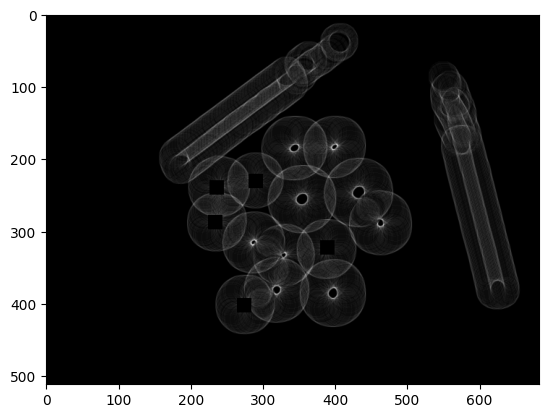

In [275]:
peaks = hough_peaks(h, thresh=45, n_size=10)

Implement a function  find_circles that combines the above two steps, searching for circles within a given radius range, and returns circle centers along with their radii:

In [276]:
def hough_circles_draw(image, pxpyr, output_file='./out_file.jpeg'):
    for peak in pxpyr:
        cv2.circle(image, (peak[1], peak[0]), peak[2], (0,255,0), 2)
    plt.imshow(image[:,:,::-1])
    return image

In [277]:
def find_close_peaks(p_storage):
    valid_idxs = range(0, len(p_storage))
    usd_idxs = []
    p_similar_storage = []
    while len(valid_idxs) > 0:
        batch = []
        main_peak = p_storage[valid_idxs[0]]
        batch.append(main_peak)
        usd_idxs.append(valid_idxs[0])
        valid_idxs = [idx for idx in valid_idxs if idx not in usd_idxs]
        for i in valid_idxs:
            is_close = np.isclose(main_peak, p_storage[i], atol=10)
            if is_close[0] and is_close[1] and is_close[2]:
                usd_idxs.append(i)
                batch.append(p_storage[i])
        p_similar_storage.append(batch)
    return p_similar_storage

def make_p_storage(edges, rs, thresh, n_size):
    p_storage = []
    for r in rs:
        h = hough_circles_acc(edges, radius=r)
        peaks = hough_peaks(h, thresh, 25, n_size, disable_plt=True)
        if len(peaks) > 0:
            for peak in peaks:
                p_storage.append([peak[0], peak[1], r])
    return p_storage 

def avg_peaks(p_storage):
    close_peaks = find_close_peaks(p_storage)
    for idx, peaks in enumerate(close_peaks):
        close_peaks[idx] = np.mean(np.asarray(peaks), axis=0).astype(int)
    return close_peaks

def find_circles(edges, image, output_file, rs=np.arange(10,50), thresh=75, n_size=10):
    p_storage = make_p_storage(edges, rs, thresh, n_size)
    pxpyr = avg_peaks(p_storage)
    image = hough_circles_draw(image=image, output_file=output_file, pxpyr=pxpyr) 
    return image



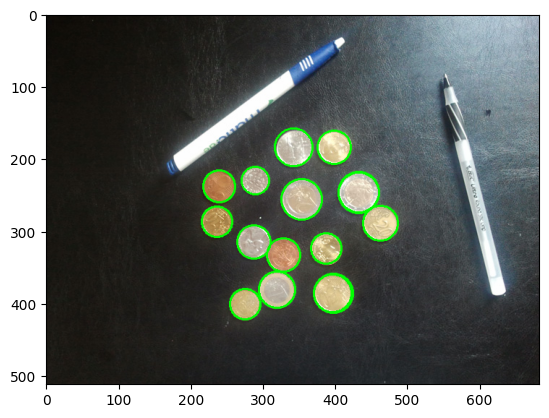

In [278]:
image = cv2.imread('./input/ps1-input1.png')
edges = cv2.Canny(circles_smooth, 40, 100)
image = find_circles(edges, image=image, output_file='./output/ps1-5-b-1.png', thresh=80, n_size=20) 

### More realistic images. Now that you have Hough methods working, we’re going to try them on images that have clutter in them - visual elements that are not part of the objects to be detected. The image to use is ps1-input2.png.

Apply your line finder. Use a smoothing filter and edge detector that seems to work best in terms of finding all the pen edges. Don’t worry (until b) about whether you are finding other lines.

Text(0.5, 1.0, 'edges')

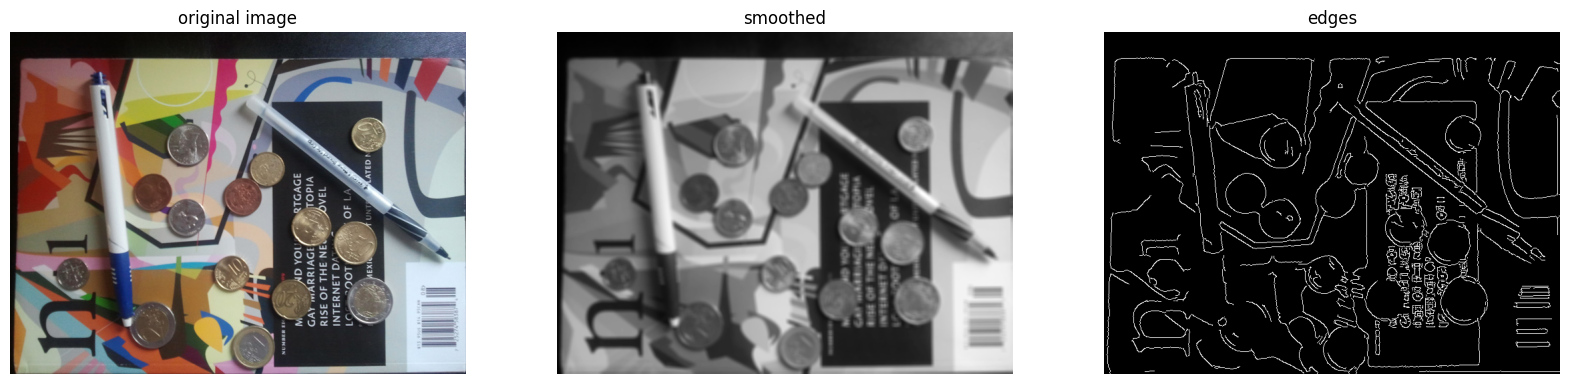

In [279]:
image = cv2.imread('./input/ps1-input2.png')

image_monochrome = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_smoothed = cv2.GaussianBlur(image_monochrome, (7, 7), 5)
image_edges = cv2.Canny(image_smoothed, 50, 100)

fig = plt.figure(figsize=(20,20))
cols = 3
rows = 1

fig.add_subplot(rows, columns, 1)
  
plt.imshow(image[:, :, ::-1])
plt.axis('off')
plt.title("original image")

fig.add_subplot(rows, columns, 2)
  
plt.imshow(image_smoothed, cmap="gray")
plt.axis('off')
plt.title("smoothed")

fig.add_subplot(rows, columns, 3)
  
plt.imshow(image_edges, cmap="gray")
plt.axis('off')
plt.title("edges")


In [280]:
def pen_filter(peaks):
    valid_idxs = range(0, len(peaks))
    usd_idxs = []
    close_lines = []
    while len(valid_idxs) > 0:
        batch = []
        main_peak = peaks[valid_idxs[0]]
        batch.append(main_peak)
        usd_idxs.append(valid_idxs[0])
        valid_idxs = [idx for idx in valid_idxs if idx not in usd_idxs]
        for i in valid_idxs:
            is_close_rho = np.isclose(main_peak, peaks[i], atol=100)
            is_close_theta = np.isclose(main_peak, peaks[i], atol=3)
            if is_close_rho[0] and is_close_theta[1]:
                usd_idxs.append(i)
                batch.append(peaks[i])
        if len(batch) > 1:
            close_lines.append(batch)
    return np.reshape(close_lines, (-1, 2))   
   

peaks found by threshold: 9


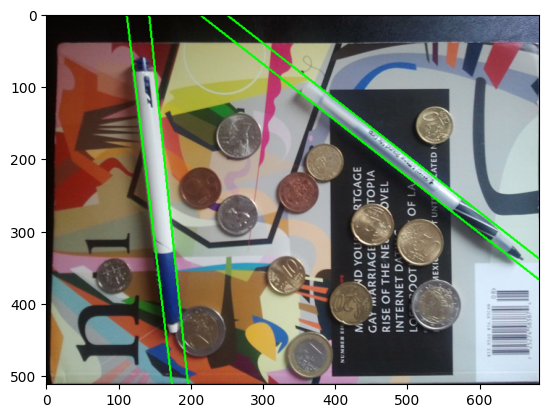

In [281]:
image = cv2.imread('./input/ps1-input2.png')
h, thetas, rhos = hough_lines_acc(image_edges, 1, np.arange(-80, 100, 1))
peaks = hough_peaks(h,thresh=120, n_size=20)
filtered_peaks = pen_filter(peaks)
img = hough_lines_draw(image, './output/ps1-6-a-1.png',filtered_peaks, rhos, thetas)

Attempt to find only the lines that are the *boundaries* of the pen.  Three operations you need to try are better thresholding in finding the lines (look for stronger edges), checking the minimum length of the line, looking for nearby parallel lines.

Text(0.5, 1.0, 'edges')

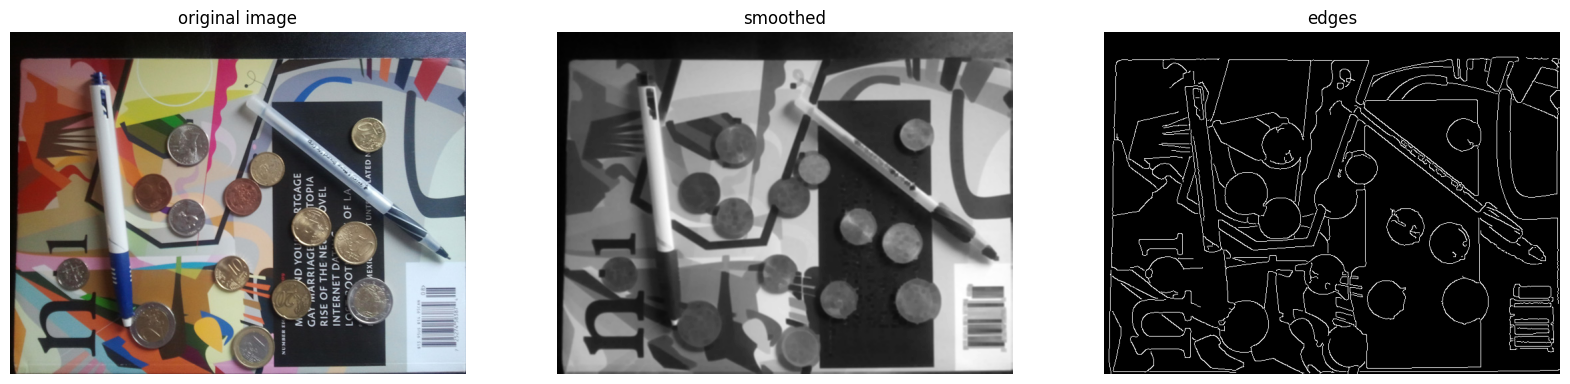

In [282]:
image = cv2.imread('./input/ps1-input2.png')

image_monochrome = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
eroded_img = cv2.erode(image_monochrome, np.ones((5,5),np.uint8), 1)
image_smoothed = cv2.blur(eroded_img, (3, 3))
image_edges = cv2.Canny(image_smoothed, 40, 100)

fig = plt.figure(figsize=(20,20))
cols = 3
rows = 1

fig.add_subplot(rows, columns, 1)
  
plt.imshow(image[:, :, ::-1])
plt.axis('off')
plt.title("original image")

fig.add_subplot(rows, columns, 2)
  
plt.imshow(image_smoothed, cmap="gray")
plt.axis('off')
plt.title("smoothed")

fig.add_subplot(rows, columns, 3)
  
plt.imshow(image_edges, cmap="gray")
plt.axis('off')
plt.title("edges")

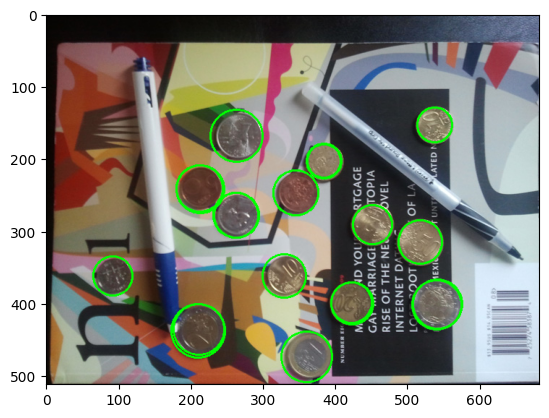

In [283]:
image = cv2.imread('./input/ps1-input2.png')
img = find_circles(image_edges, image, './output/ps1-7-a-1.png', thresh=80, n_size=30)

Text(0.5, 1.0, 'edges')

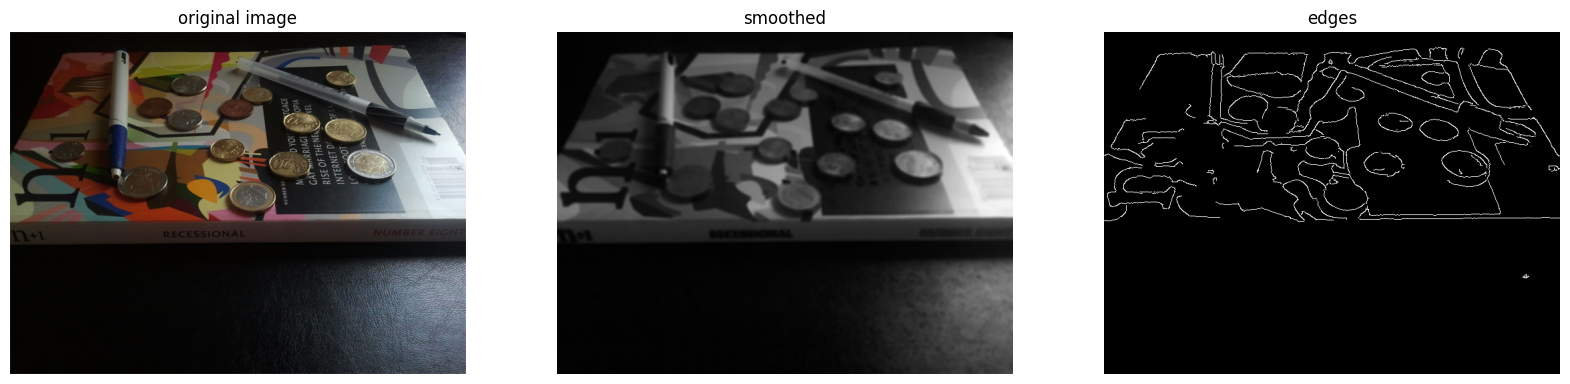

In [318]:
image = cv2.imread('./input/ps1-input3.png')

image_monochrome = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
eroded_img = cv2.erode(image_monochrome, np.ones((5,5),np.uint8), 1)
image_smoothed = cv2.blur(eroded_img, (5, 5))
image_edges = cv2.Canny(image_smoothed, 40, 80)

fig = plt.figure(figsize=(20,20))
cols = 3
rows = 1

fig.add_subplot(rows, columns, 1)
  
plt.imshow(image[:, :, ::-1])
plt.axis('off')
plt.title("original image")

fig.add_subplot(rows, columns, 2)
  
plt.imshow(image_smoothed, cmap="gray")
plt.axis('off')
plt.title("smoothed")

fig.add_subplot(rows, columns, 3)
  
plt.imshow(image_edges, cmap="gray")
plt.axis('off')
plt.title("edges")

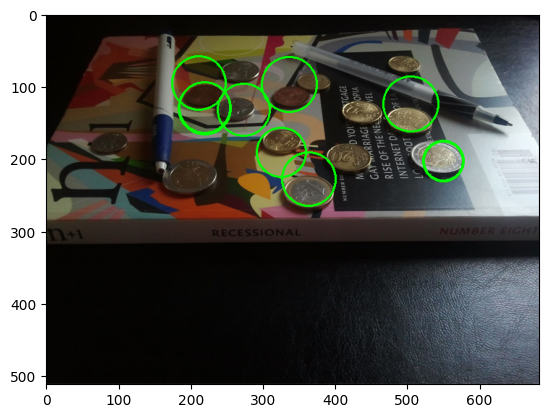

In [325]:
image = cv2.imread('./input/ps1-input3.png')
img = find_circles(image_edges, image, './output/ps1-8-a-1.png', thresh=60, n_size=4,rs=np.arange(2, 40))